In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

ERROR: Invalid requirement: "'git+https://github.com/facebookresearch/detectron2.git'"


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import torch

# import some common libraries
import numpy as np
import os, json, cv2, random
from scipy import ndimage

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import yaml
import csv
import cv2
from pathlib import Path
import shutil


from PIL import Image
from tqdm import tqdm
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from skimage.exposure import match_histograms
import time

ModuleNotFoundError: No module named 'detectron2'

In [4]:
def segment_detectron2(data, ndata, cfg, mode):
    if ndata==0:
        ndata=data.shape[0]
    D=[]
    predictor = DefaultPredictor(cfg)
    SE= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))

    t = time.time()
    for i in range(ndata):
        new_im = data[i]
        outputs  = predictor(new_im)
        category = outputs["instances"].pred_classes
        #category[category==2]=0
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)
        Z = np.zeros((mask.shape[1],mask.shape[2]),dtype="uint8")
        for idx in range(mask.shape[0]):
            if (mask[idx].sum()<2000) or (mode=='phase'):
                msk=(np.uint8(category[idx].cpu())+1)*mask[idx]
                if mode=='phase':
                    msk=cv2.erode(msk.astype('float32'), SE, iterations=1)
                Z=Z*(~(msk>0))+msk
        D.append(Z)
        elapsed = time.time() - t
        print('Time required for processing all data: ', elapsed)
        clear_output(wait=True)
        print('frame ',i+1,'/',ndata)
    D=np.array(D)
    print('Completed')
    return D

['frame_Phase_1.jpg', 'frame_Phase_2.jpg', 'frame_Phase_3.jpg', 'frame_Phase_4.jpg', 'frame_Phase_5.jpg', 'frame_Phase_6.jpg', 'frame_Phase_7.jpg', 'frame_Phase_8.jpg', 'frame_Phase_9.jpg', 'frame_Phase_10.jpg', 'frame_Phase_11.jpg', 'frame_Phase_12.jpg', 'frame_Phase_13.jpg', 'frame_Phase_14.jpg', 'frame_Phase_15.jpg', 'frame_Phase_16.jpg', 'frame_Phase_17.jpg', 'frame_Phase_18.jpg', 'frame_Phase_19.jpg', 'frame_Phase_20.jpg', 'frame_Phase_21.jpg', 'frame_Phase_22.jpg', 'frame_Phase_23.jpg', 'frame_Phase_24.jpg', 'frame_Phase_25.jpg', 'frame_Phase_26.jpg', 'frame_Phase_27.jpg', 'frame_Phase_28.jpg', 'frame_Phase_29.jpg', 'frame_Phase_30.jpg', 'frame_Phase_31.jpg', 'frame_Phase_32.jpg', 'frame_Phase_33.jpg', 'frame_Phase_34.jpg', 'frame_Phase_35.jpg', 'frame_Phase_36.jpg', 'frame_Phase_37.jpg', 'frame_Phase_38.jpg', 'frame_Phase_39.jpg', 'frame_Phase_40.jpg', 'frame_Phase_41.jpg', 'frame_Phase_42.jpg', 'frame_Phase_43.jpg', 'frame_Phase_44.jpg', 'frame_Phase_45.jpg', 'frame_Phase_46.jp

100%|██████████| 173/173 [00:03<00:00, 54.83it/s] 


training set shape (173, 768, 768, 3)
training set max 255


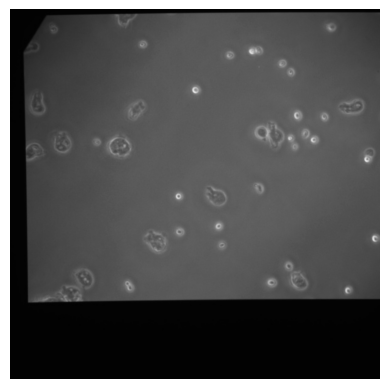

In [5]:
# input parameters
imsize=768 # 768, 1024
image_format = 'jpg' # e.g .png, .svg, etc.
img_dpi=1200

source3=r"/content/drive/MyDrive/Sure Scheme/Segmentation/Phase"


#num_images = 350
sorted_list_dataset = os.listdir(source3)
sorted_list_dataset.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

print(sorted_list_dataset)


Dataset = []
for idx in tqdm(sorted_list_dataset):
      filepath = os.path.join(source3,idx)
      if filepath.endswith(('.jpg')):
          file = mpimg.imread(filepath)
          file=cv2.resize(file,(imsize,imsize))
          # Contrast stretching
          #p2 = np.percentile(file, 17) #np.percentile() : Compute the q-th percentile of the data along the specified axis.
          #p98 = np.percentile(file, 98)
          #file = exposure.rescale_intensity(file, in_range=(p2, p98)) # exposure.rescale_intensity() : Return image after stretching or shrinking its intensity levels.
          #file = match_histograms(file, reference3)
          Dataset.append(file)
Dataset=np.array(Dataset)
Dataset=((Dataset-Dataset.min())/Dataset.max())*255 ##QUESTION
Dataset=np.uint8(Dataset)
######################################################################################################################

#Dataset = np.stack((Dataset,)*3,axis=-1)
print('training set shape', Dataset.shape)
print('training set max', Dataset.max())



plt.imshow(Dataset[0],cmap='gray')
plt.axis("off")
plt.show()


In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training
cfg.MODEL.WEIGHTS = r"/content/drive/MyDrive/Sure Scheme/Segmentation/Dataset_Amoebas_Yeast_Phase v2/model1/model_final.pth"
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.DEVICE='cpu'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # We have 200 classes.
cfg.TEST.DETECTIONS_PER_IMAGE= 300
cfg.MODEL.DEVICE='cpu'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


frame  5 / 5
Completed


In [9]:
input_images_directory = source3
output_directory = r'/content/drive/MyDrive/Sure Scheme/Segmentation 3/Phase_masks'

shutil.rmtree(output_directory) #remakes output directory
os.mkdir(output_directory)

num_images = 10
dirFiles = os.listdir(input_images_directory)
dirFiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

classes = ["amoeba", "yeast"]

for i, image_filename in enumerate(dirFiles[:num_images]):
    sys.stdout.write(f'\rSegmenting image {i+1} / {len(os.listdir(input_images_directory)[:num_images])}')
    #sys.stdout.write(f'\rSegmenting image {i+1} / {len(os.listdir(input_images_directory)[:5])}') # Test
    sys.stdout.flush()
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # Create a dictionary to store the mask for each class with unique integer labels
    class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.int16,)
                   for class_name in classes}

    # Assign a unique integer label to each object in the mask
    for i, pred_class in enumerate(outputs["instances"].pred_classes):
        class_name = classes[pred_class]
        instance_mask = outputs["instances"].pred_masks[i]
        class_masks[class_name] = torch.where(instance_mask,
                                      torch.tensor(i + 1, dtype=torch.float32),
                                      class_masks[class_name].to(dtype=torch.float32))
        class_masks[class_name] = class_masks[class_name].to(dtype=torch.int16)




    for class_name, class_mask in class_masks.items():
        class_mask_np = class_mask.cpu().numpy()
        image_name = os.path.splitext(image_filename)[0] + f'_{class_name}.tif'

        output_path = os.path.join(output_directory, class_name)
        os.makedirs(output_path, exist_ok=True)

        #image_name = os.path.splitext(image_filename)[0] + '.png'
        Image.fromarray(class_mask_np.astype(np.uint16)).save(Path(output_path) / image_name)
        #sys.stdout.write(f"\n Saved mask for class {class_name}")

Segmenting image 10 / 10